<a href="https://colab.research.google.com/github/Samin-Sadaf7/NN_works/blob/main/makemore_v3_mlp_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [36]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [37]:
# download the names.txt file from github
!wget https://raw.githubusercontent.com/karpathy/makemore/master/names.txt

--2024-07-04 04:23:01--  https://raw.githubusercontent.com/karpathy/makemore/master/names.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228145 (223K) [text/plain]
Saving to: ‘names.txt.1’

names.txt.1         100%[===================>] 222.80K  --.-KB/s    in 0.02s   

2024-07-04 04:23:01 (9.18 MB/s) - ‘names.txt.1’ saved [228145/228145]



In [38]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [39]:
len(words)

32033

In [40]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [41]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):
  X, Y = [], []

  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [42]:
# MLP revisited
n_embd = 10
n_hidden = 200

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g)
b1 = torch.randn(n_hidden,                        generator=g)
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

parameters = [C, W1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

11697


In [43]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  # Linear layer
  hpreact = embcat @ W1 #+ b1 # hidden layer pre-activation

  # -------------------------------------------------------------
  # Non-linearity
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  break

      0/ 200000: 3.3277


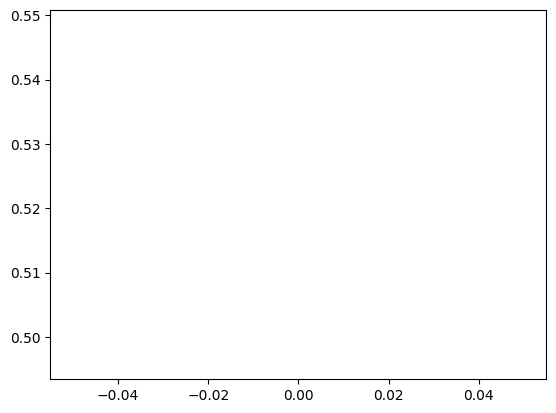

In [44]:
plt.plot(lossi)

We initialized the W1 to be very close to zero to get a lower loss initially. Because it will help the gradient move onto the toughest road to optimize the loss function. It will not go move to the smooth part. So there is no smoothly decreasing line in the graph.

In [45]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1  + b1
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 3.2052221298217773
val 3.204833745956421


**Problems** with value of **h** :
1. In the plot: the output of tanh is 1 or -1
2. While calculating gradient it becomes close to 0
3. So, it is not updating or decreasing the loss
4. If tanh=0, outgrad flows through no impact of tanh

(array([2069.,  145.,  101.,   73.,   68.,   48.,   42.,   44.,   32.,
          47.,   38.,   28.,   32.,   22.,   30.,   21.,   20.,   16.,
          15.,   14.,   23.,   27.,   14.,   20.,   23.,   29.,   25.,
          18.,   21.,   26.,   21.,   27.,   21.,   18.,   12.,   34.,
          32.,   21.,   28.,   31.,   35.,   23.,   50.,   35.,   47.,
          68.,   96.,  116.,  172., 2382.]),
 array([-1.  , -0.96, -0.92, -0.88, -0.84, -0.8 , -0.76, -0.72, -0.68,
        -0.64, -0.6 , -0.56, -0.52, -0.48, -0.44, -0.4 , -0.36, -0.32,
        -0.28, -0.24, -0.2 , -0.16, -0.12, -0.08, -0.04,  0.  ,  0.04,
         0.08,  0.12,  0.16,  0.2 ,  0.24,  0.28,  0.32,  0.36,  0.4 ,
         0.44,  0.48,  0.52,  0.56,  0.6 ,  0.64,  0.68,  0.72,  0.76,
         0.8 ,  0.84,  0.88,  0.92,  0.96,  1.  ]),
 <BarContainer object of 50 artists>)

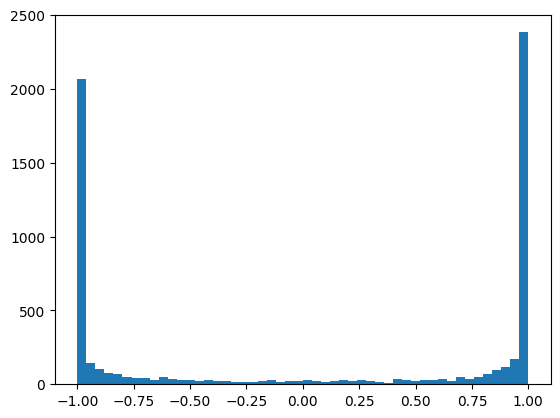

In [46]:
plt.hist(h.view(-1).tolist(),50)

(array([  1.,   2.,   0.,   1.,   5.,   3.,  11.,   6.,  13.,  10.,  25.,
         40.,  39.,  77.,  64.,  99., 134., 169., 187., 219., 224., 275.,
        308., 311., 355., 369., 379., 357., 366., 333., 292., 284., 287.,
        244., 187., 170., 134., 104.,  82.,  74.,  41.,  30.,  27.,  19.,
         12.,   7.,  12.,   3.,   2.,   7.]),
 array([-18.80574417, -18.08757278, -17.3694014 , -16.65123001,
        -15.93305862, -15.21488724, -14.49671585, -13.77854446,
        -13.06037308, -12.34220169, -11.6240303 , -10.90585892,
        -10.18768753,  -9.46951614,  -8.75134476,  -8.03317337,
         -7.31500198,  -6.5968306 ,  -5.87865921,  -5.16048782,
         -4.44231644,  -3.72414505,  -3.00597366,  -2.28780228,
         -1.56963089,  -0.8514595 ,  -0.13328812,   0.58488327,
          1.30305466,   2.02122604,   2.73939743,   3.45756882,
          4.1757402 ,   4.89391159,   5.61208298,   6.33025436,
          7.04842575,   7.76659714,   8.48476852,   9.20293991,
          9.921111

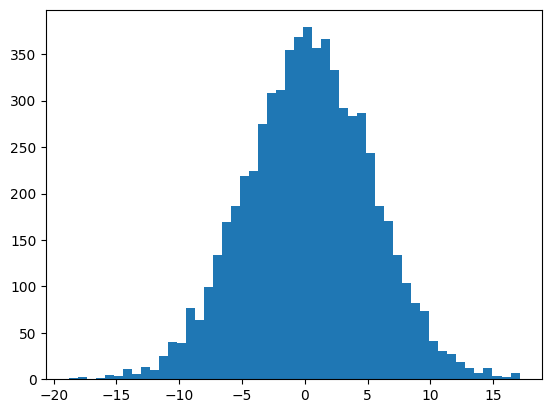

In [47]:
plt.hist(hpreact.view(-1).tolist(),50)

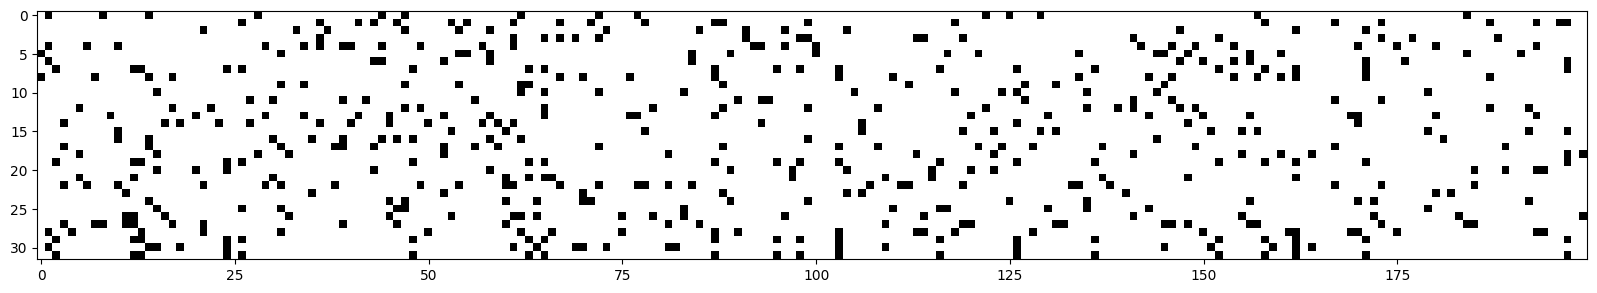

In [48]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs()>0.5, cmap='gray', interpolation='nearest')

**To Solve** this issue we need h pre activation should be close to 0. It should not be too far off the 0.

In [49]:
# MLP revisited
n_embd = 10
n_hidden = 200

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * 0.2
b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

parameters = [C, W1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

11697


In [50]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  # Linear layer
  hpreact = embcat @ W1 #+ b1 # hidden layer pre-activation

  # -------------------------------------------------------------
  # Non-linearity
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  #break

      0/ 200000: 3.3134
  10000/ 200000: 2.1660
  20000/ 200000: 2.3240
  30000/ 200000: 2.3918
  40000/ 200000: 1.9870
  50000/ 200000: 2.2887
  60000/ 200000: 2.4205
  70000/ 200000: 2.1077
  80000/ 200000: 2.2996
  90000/ 200000: 2.1169
 100000/ 200000: 1.8800
 110000/ 200000: 2.1717
 120000/ 200000: 1.9890
 130000/ 200000: 2.4198
 140000/ 200000: 2.2000
 150000/ 200000: 2.1517
 160000/ 200000: 1.8120
 170000/ 200000: 1.8149
 180000/ 200000: 1.9480
 190000/ 200000: 1.8681


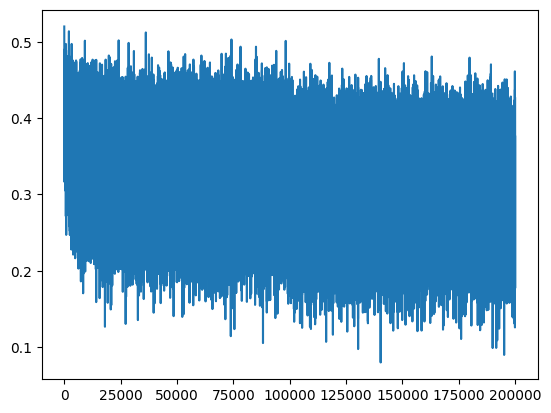

In [51]:
plt.plot(lossi)

In [52]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1  + b1
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.035963535308838
val 2.1026062965393066


(array([ 904.,  249.,  146.,  117.,  110.,   93.,   79.,   63.,   59.,
          59.,   75.,   62.,   60.,   37.,   88.,   87.,   77.,  112.,
          80.,   70.,  104.,  140.,   65.,  124.,  101.,  118.,   73.,
          93.,  105.,   90.,   62.,  100.,   64.,   48.,   85.,   69.,
          54.,   54.,   70.,   58.,   50.,   79.,   83.,   81.,   84.,
         134.,  146.,  157.,  257., 1025.]),
 array([-1.00000000e+00, -9.60000004e-01, -9.20000007e-01, -8.80000011e-01,
        -8.40000014e-01, -8.00000018e-01, -7.60000021e-01, -7.20000025e-01,
        -6.80000029e-01, -6.40000032e-01, -6.00000036e-01, -5.60000039e-01,
        -5.20000043e-01, -4.80000046e-01, -4.40000050e-01, -4.00000054e-01,
        -3.60000057e-01, -3.20000061e-01, -2.80000064e-01, -2.40000068e-01,
        -2.00000072e-01, -1.60000075e-01, -1.20000079e-01, -8.00000823e-02,
        -4.00000858e-02, -8.94069673e-08,  3.99999070e-02,  7.99999034e-02,
         1.19999900e-01,  1.59999896e-01,  1.99999893e-01,  2.399998

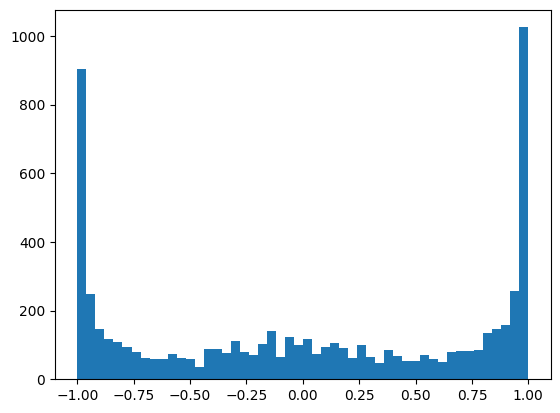

In [53]:
plt.hist(h.view(-1).tolist(),50)

(array([  1.,   0.,   0.,   0.,   1.,   2.,   1.,   3.,   3.,   3.,   4.,
          8.,  14.,  17.,  24.,  29.,  48.,  66.,  63.,  98., 120., 131.,
        188., 238., 268., 333., 362., 624., 964., 561., 384., 372., 271.,
        274., 188., 170., 131., 122.,  93.,  50.,  54.,  29.,  22.,  24.,
         18.,   8.,   6.,   5.,   1.,   4.]),
 array([-10.86410618, -10.48289787, -10.10168957,  -9.72048126,
         -9.33927296,  -8.95806465,  -8.57685635,  -8.19564804,
         -7.81443974,  -7.43323143,  -7.05202312,  -6.67081482,
         -6.28960651,  -5.90839821,  -5.5271899 ,  -5.1459816 ,
         -4.76477329,  -4.38356499,  -4.00235668,  -3.62114838,
         -3.23994007,  -2.85873177,  -2.47752346,  -2.09631516,
         -1.71510685,  -1.33389854,  -0.95269024,  -0.57148193,
         -0.19027363,   0.19093468,   0.57214298,   0.95335129,
          1.33455959,   1.7157679 ,   2.0969762 ,   2.47818451,
          2.85939281,   3.24060112,   3.62180943,   4.00301773,
          4.384226

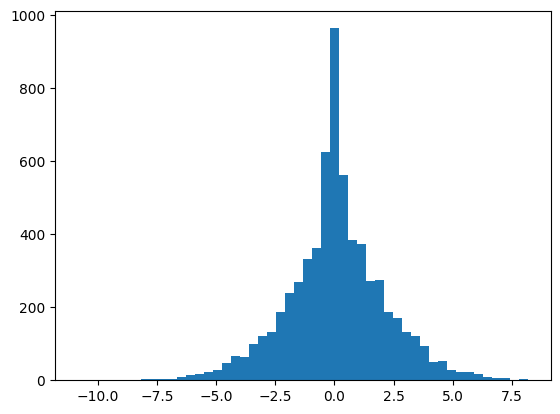

In [54]:
plt.hist(hpreact.view(-1).tolist(),50)

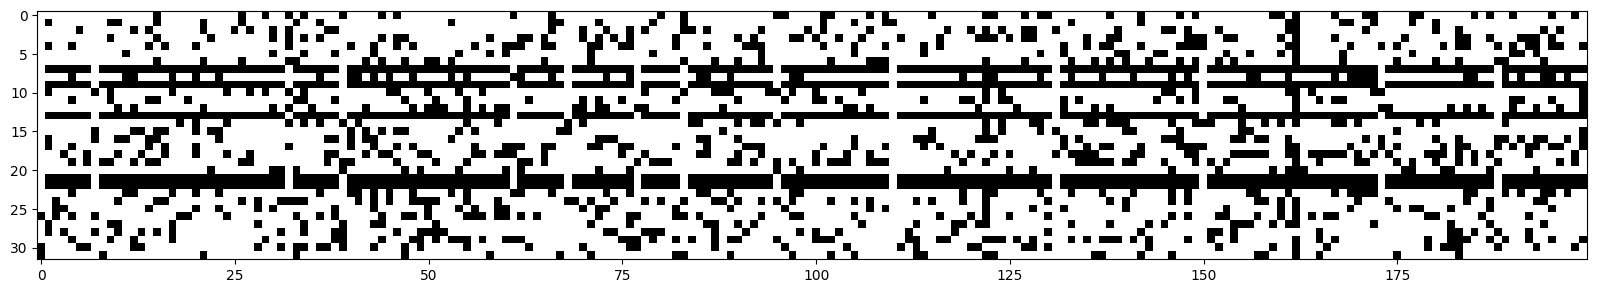

In [55]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs()>0.5, cmap='gray', interpolation='nearest')